In [18]:
#Primero, importamos todos los paquetes necesarios.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
import netCDF4 as nc
from scipy import stats as sts
import scipy.stats as stats
from scipy import signal
from scipy.fft import fft 
from statsmodels.tsa import stattools 
from cartopy import crs as ccrs # Cartography library
import cartopy as car
import cmocean as cmo #Oceanographic library for colormaps
import matplotlib.patches as mpatches
import cartopy.io.img_tiles as cimgt
import numpy.linalg as linalg
import numpy.ma as ma
from scipy.stats import pearsonr
import matplotlib.dates as mdates
import cartopy.io.shapereader as shpreader


# Índices Climáticos
from xclim.core.calendar import percentile_doy
from xclim.indices import tn10p, tx10p

In [29]:
percentil10_minimas= xr.open_dataset('datos_indices/tmax_p10_ESP.nc')
percentil10_maximas= xr.open_dataset('datos_indices/tmin_p10_ESP.nc')
porcentaje_dias= xr.open_dataset('datos_indices/Tx10p_ESP_nan.nc')
porcentaje_noches= xr.open_dataset('datos_indices/Tn10p_ESP_nan.nc')

tn10=porcentaje_noches
tx10=porcentaje_dias

tn10=tn10.__xarray_dataarray_variable__
tx10=tx10.__xarray_dataarray_variable__

#hacemos un remallado para reducir la dimensionalidad de los datos
tn10_remallado=tn10.interp(lat=tn10.lat[::2]).interp(lon=tn10.lon[::2])
tn10_remallado=tn10_remallado.set_index(lon='x')
tn10_remallado=tn10_remallado.set_index(lat='y')

lon = tn10_remallado.lon
lat = tn10_remallado.lat

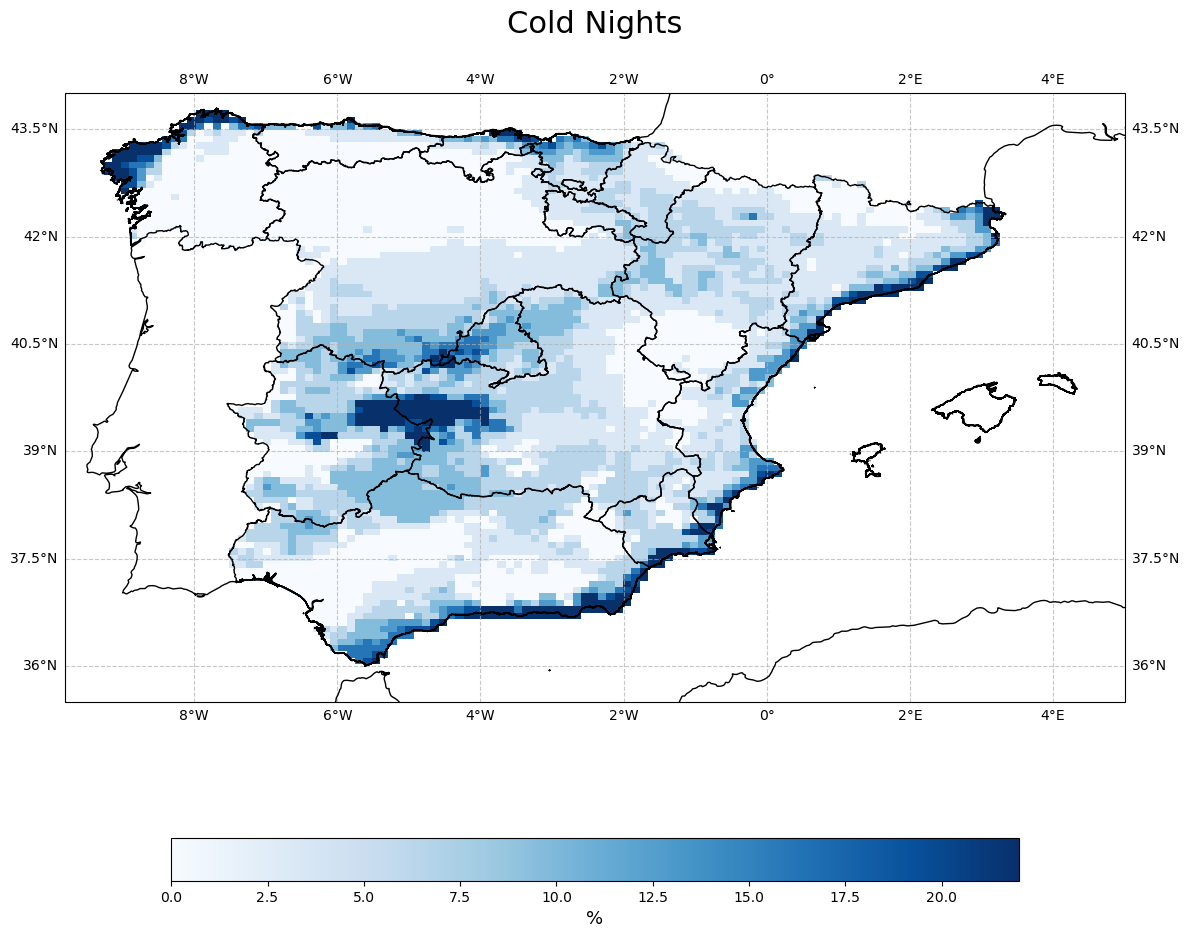

In [31]:
plt.style.use('default')
  
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = 'datos_indices/mapas/gadm41_ESP_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())

# Creamos la figura
fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
plt.suptitle('Cold Nights',size=22)

# A partir de aquí vamos a pintar los valores promedio de noches frías en el periodo empleado   
cmap = 'Blues'
var = tn10_remallado.sel(time='1901-01-01')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que están los datos 
#print(var.max().squeeze())

# Pintamos las líneas de costa y las fronteras de comunidades
ax.coastlines(resolution='10m')
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_global() 
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1) # Añadimos ejes
ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree()) # Fijamos los límites del plot


# Barra de color 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8) 
cbar.set_label(label='%',size=13)
cbar.ax.set_xlim(0, 22) # Al poner los mismos vmin y vmax aseguramos que la escala sea consistente en cada parte

plt.tight_layout()

Vamos a tomar los índices de noches y días fríos para la región sur y los vamos a diagonalizar

In [36]:
nt,nlat,nlon=tn10_remallado.shape
nyears=int(nt/12)
tn10_array=np.asarray(tn10_remallado)

In [35]:
def season(Z,e1,e2,nyrs):
#para que funcione los datos Z tienen que estar con dimensiones nyrs,12,ns
#e1 y e2 son los meses inicial y final de las estaciones
#e1=2;e2=4 ;esta='MAM';
#e1=5;e2=7 ;esta='JJA';
#e1=6;e2=8 ;esta='JAS';
#e1=8;e2=10 ;esta='SON';
#e1=11;e2=1 ;esta='DJF';
#e1=10;e2=1 ;esta='NDJF';
   
    if e1==11:
        Zs1= Z[:-1,e1,:]
        Zs2= Z[1:,:e2,:].mean(1)
        n1=1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    elif e1>e2:
        Zs1= Z[:-1,e1:11,:].mean(1)
        Zs2= Z[1:,:e2,:].mean(1)
        n1=12-e1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    else:
        Zs = Z[:,e1:e2,:].mean(1)

    return Zs ,nyrs

# Esta función te proporciona anomalías ya sean estandarizadas o no, al introducir un campo con dimension (espacio,tiempo)
def anom(X, nyr, par):
    # si par = st quiere decir que estandarizo. Si no, no (pongo, por ejemplo,'pp')
    ns, nt = np.shape(X)  # una de las dimensiones es tiempo, la segunda, y la otra puede ser el numero de modos, o de espacios..
    nmes = int(nt / (nyr));

    # dividimos el número de tiempos por el numero de años porque en caso de que queramos calcular
    # anomalias estacionales de una secuencia mensual (enero-media(diciembre-enero-febrero)) en lugar de una media estacional

    An = ma.empty([ns, nt])

    for i in range(ns):
        A = X[i, :].reshape(nyr, nmes)
        mA = np.mean(A)
        for j in range(0, nyr):
            A[j, :] = A[j, :] - mA

        if par == 'st':

            stdA = ma.empty([nmes, ])
            for k in range(nmes):
                stdA[k] = np.std(A[:, k])
                if stdA[k] != 0:
                    A[:, k] = A[:, k] / stdA[k]

        # se reorganizan los datos
        A = np.transpose(A.reshape(nyr * nmes, 1))
        An[i, :] = A;

    return An

In [44]:
nlatitud=tn10_array.shape[1]
nlongitud=tn10_array.shape[2]
tn10_primavera_reshape=np.reshape(tn10_array, (nyears,12,nlat*nlon))
tn10_primavera,ny1=season(tn10_primavera_reshape,2,4,nyears)
tn10_primavera_prueba_anomalia=(tn10_array-tn10_array.mean(axis=0))/tn10_array.std(axis=0)
[nt_prueba,nlat_prueba,nlon_prueba]=tn10_primavera_prueba_anomalia.shape
tn10_prima_pr_anom_resh=np.reshape(np.array(tn10_primavera_prueba_anomalia), (int(nt_prueba/12),12,nlat_prueba,nlon_prueba)).mean(axis=1)
tn10_prim_nans=np.reshape(tn10_prima_pr_anom_resh,(114,nlat_prueba*nlon_prueba))

def quitonans(mat):
    out = mat[:,~np.isnan(mat.mean(axis = 0))]
    return out

def pongonans(matred,mat):
    out = mat.mean(axis = 0 )
    out[:] = np.nan
    out[~np.isnan(mat.mean(axis = 0))] = matred
    return out

In [49]:
tn10_primavera_sin_nan=quitonans(tn10_prim_nans)
C=np.dot(np.transpose(tn10_primavera_sin_nan),tn10_primavera_sin_nan)
eof_tn10,d_tn10,eof2_tn10=linalg.svd(C)

fvar_tn10=(d_tn10)/sum(d_tn10)
sum(fvar_tn10[:10])

0.8635286092841207

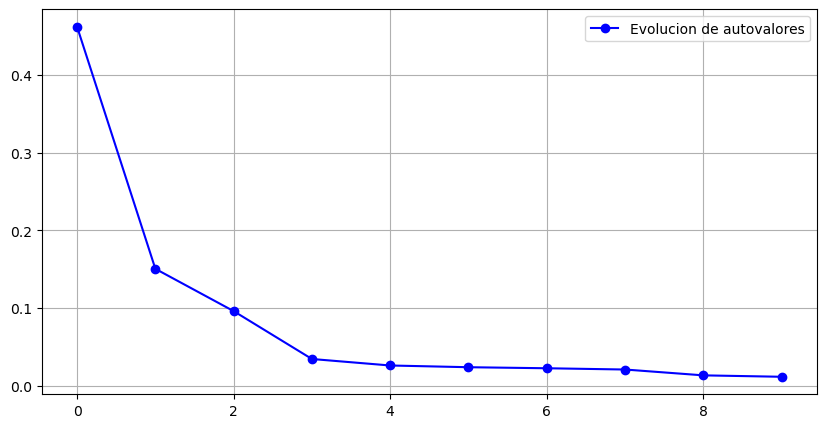

In [50]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar_tn10[:10],color='Blue',marker='o',label='Evolucion de autovalores')
plt.legend()
plt.grid()

Text(0.5, 1.0, 'Primera componente principal fvar=0.46')

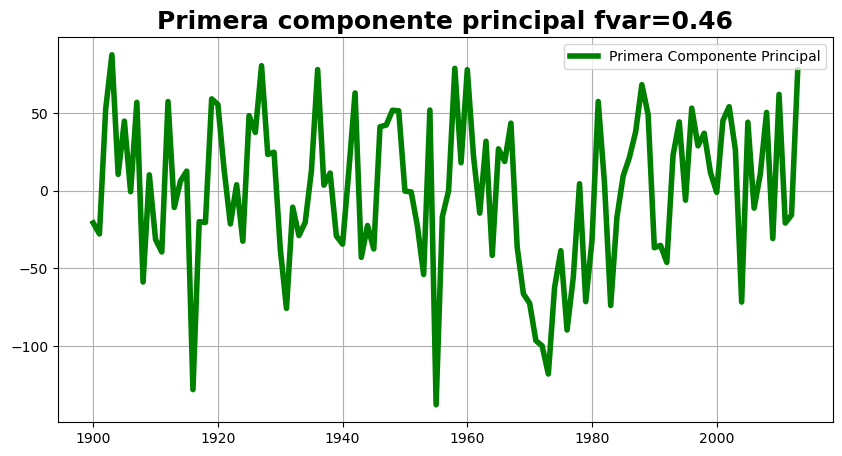

In [51]:
PC=np.dot(tn10_primavera_sin_nan,eof_tn10)
PCs=(PC-np.mean(PC))/np.std(PC)
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1900,2014),PCs[:,0],linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Primera componente principal fvar='+ str( round(fvar_tn10[0],2)),fontsize=18,weight='bold')

# Prueba con mi código

In [158]:
def periodo(max_data,min_data,season,periodo):
    max_data_red= max_data.sel(lon=slice(lon_lims[0],lon_lims[1]),lat=slice(lat_lims[0],lat_lims[1]), Time=(max_data.Time.dt.season == season))
    min_data_red= min_data.sel(lon=slice(lon_lims[0],lon_lims[1]),lat=slice(lat_lims[0],lat_lims[1]), Time=(min_data.Time.dt.season == season))

    max_data_red_percentil= max_data_red.sel(Time=slice('1961','1990'))
    min_data_red_percentil= min_data_red.sel(Time=slice('1961','1990'))
    
    alldata_min= min_data_red.tn
    alldata_max= max_data_red.tx

    cuantil_min= np.quantile(min_data_red_percentil.tn,0.1,axis=0)
    cuantil_max= np.quantile(max_data_red_percentil.tx,0.1,axis=0)

    n_cold_nights= np.zeros(111)
    n_cold_days= np.zeros(111)
    latitud= max_data_red.lat
    longitud= max_data_red.lon
    
    n_cold_nights_per_pixel= np.empty((111,len(latitud),len(longitud)))
    n_cold_days_per_pixel= np.empty((111,len(latitud),len(longitud)))

    print('a')
    s=0
    for i in range(1901,2012):
        a= np.sum(np.where(alldata_min[alldata_min['Time.year']==i]<cuantil_min,1,0),axis=0)
        n_cold_nights[s]= np.nanmean(np.where(np.isnan(alldata_min[alldata_min['Time.year']==i]),np.nan,a))
        n_cold_nights_per_pixel[s,:,:]= a
        
        b= np.sum(np.where(alldata_max[alldata_max['Time.year']==i]<cuantil_max,1,0),axis=0)
        n_cold_days[s]= np.nanmean(np.where(np.isnan(alldata_max[alldata_max['Time.year']==i]),np.nan,b))
        n_cold_days_per_pixel[s,:,:]= b
        #n_cold_nights[s]= np.mean(np.sum(np.where(alldata_min[alldata_min['Time.year']==i]<cuantil_min,1,0),axis=0))
        #n_cold_days[s]= np.mean(np.sum(np.where(alldata_max[alldata_max['Time.year']==i]<cuantil_max,1,0),axis=0))
        s+=1

    print('b')
    n_days_season= 90
    perc_cold_nights= (n_cold_nights/n_days_season)*100
    perc_cold_days= (n_cold_days/n_days_season)*100

    fig = plt.figure(figsize=(30,10), tight_layout=True) 
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    period= np.arange(1901,2012,1)

    ax1.plot(period,perc_cold_nights)
    ax2.plot(period,perc_cold_days)
    maximo_night= np.max(perc_cold_nights)
    minimo_night= np.min(perc_cold_nights)
    maximo_day= np.max(perc_cold_days)
    minimo_day= np.min(perc_cold_days)

    ax1.set_ylim(minimo_night,maximo_night)
    ax2.set_ylim(minimo_day,maximo_day)
    ax1.set_title('Porcentaje de noches frías',fontsize=15)
    ax2.set_title('Porcentaje de días fríos',fontsize=15)
    fig.suptitle('Porcentaje de noches y días fríos para todo en '+str(periodo)+' definiendo el percentil entre 1961-1990',fontsize=25, weight='bold')
    
    return fig, perc_cold_days, perc_cold_nights, n_cold_days_per_pixel, n_cold_nights_per_pixel, latitud, longitud, period

a
b


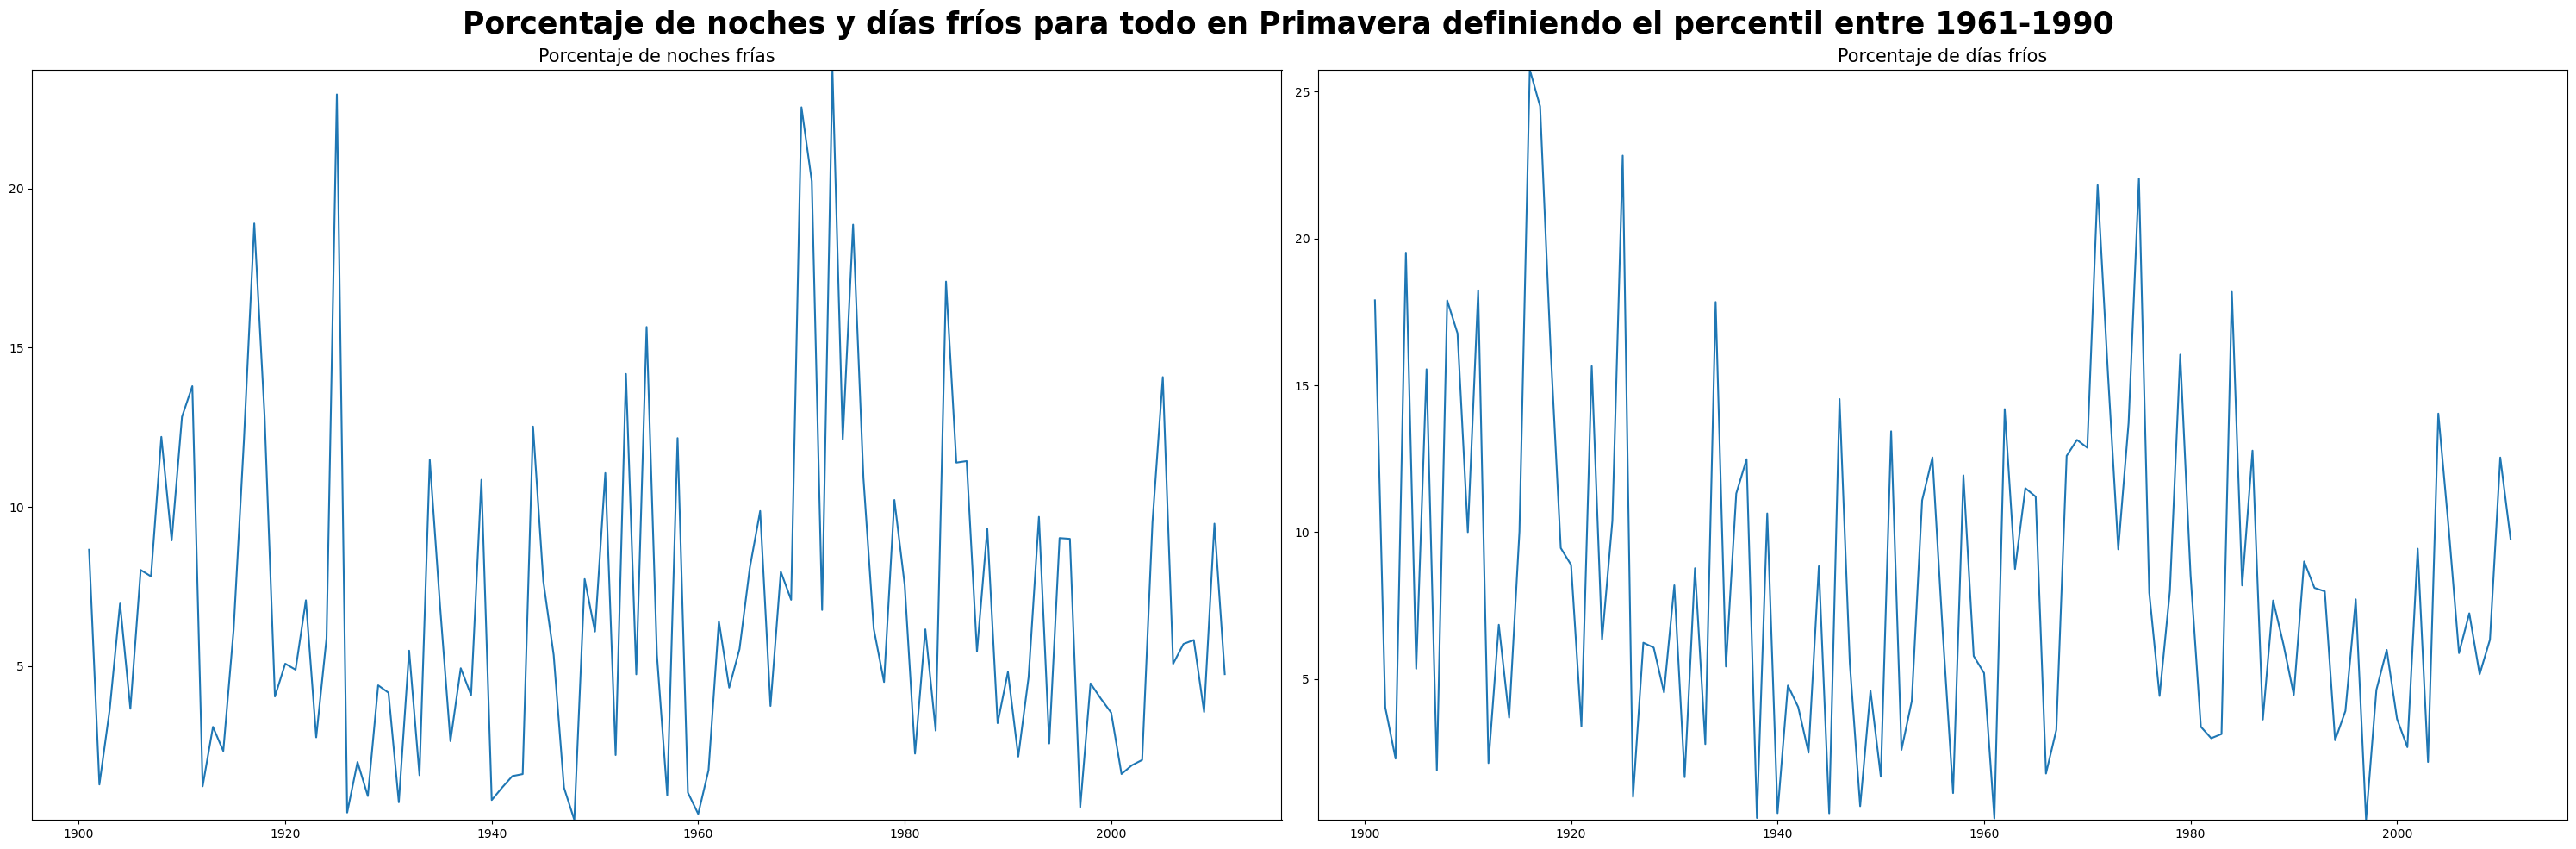

In [159]:
#Vamos a coger ahora nuestro índice de días fríos para primavera, que es donde teníamos dos picos significativos
path= r'C:/Users/ideapad 5 15ITL05/Desktop/Meteo UCM/1 cuatrimestre/Analisis de datos en meteorologia/Practica 2/'
data_max= r'Datos/tmax_pen.nc'
data_min= r'Datos/tmin_pen.nc'
max_data= xr.open_dataset(path+data_max)
min_data= xr.open_dataset(path+data_min)
#lat_lims= [38,36]
#lon_lims= [-8,0] #limites region sur

lat_lims= [44,35.5]
lon_lims= [-9.5,3.5] #toda españa

primavera= periodo(max_data,min_data,season='MAM',periodo='Primavera')
cold_days_primavera= primavera[1]

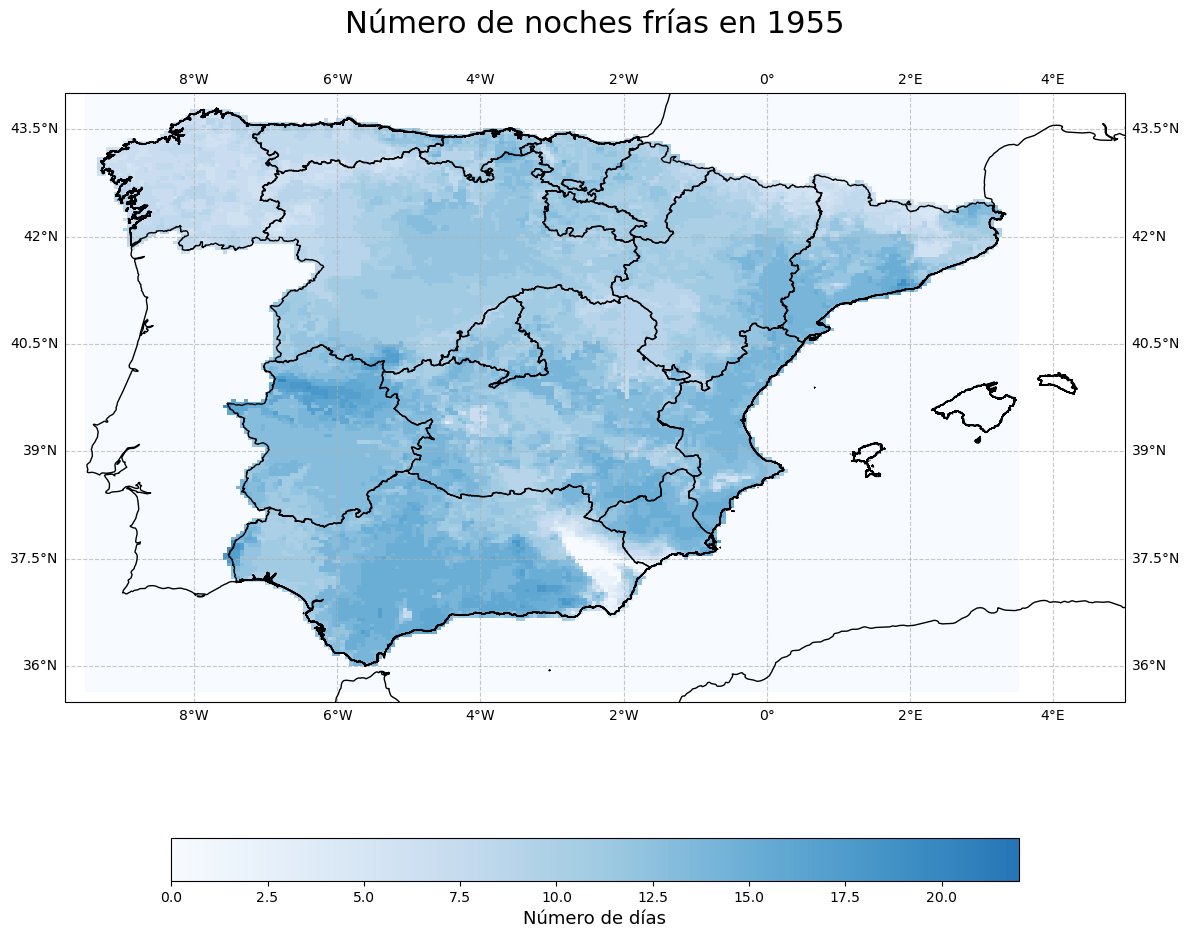

In [143]:
plt.style.use('default')
  
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = 'datos_indices/mapas/gadm41_ESP_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())

year= 1955
# Creamos la figura
fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
plt.suptitle('Número de noches frías en '+str(year),size=22)

# A partir de aquí vamos a pintar los valores promedio de noches frías en el periodo empleado   
cmap = 'Blues'
years= primavera[7]
var = primavera[3][np.where(years==year)[0],:,:].squeeze()
latitud= primavera[5]
longitud= primavera[6]
im = ax.pcolormesh(longitud,latitud,var,cmap=cmap,vmin=0, vmax=30, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que están los datos 

#print(var.max().squeeze())

# Pintamos las líneas de costa y las fronteras de comunidades
ax.coastlines(resolution='10m')
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_global() 
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1) # Añadimos ejes
ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree()) # Fijamos los límites del plot


# Barra de color 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8) 
cbar.set_label(label='Número de días',size=13)
cbar.ax.set_xlim(0, 22) # Al poner los mismos vmin y vmax aseguramos que la escala sea consistente en cada parte

plt.tight_layout()

In [189]:
#una vez tenemos el índice de días fríos para cada punto, vamos a calcular las PCs
num_nochesfrias = xr.DataArray(primavera[3], coords={'time': primavera[7],'lat': primavera[5],'lon': primavera[6]}, dims=[ "time","lat", "lon"])

#hacemos un remallado para reducir la dimensionalidad de los datos
num_nochesfrias_remallado=num_nochesfrias.interp(lat=num_nochesfrias.lat[::2]).interp(lon=num_nochesfrias.lon[::2])
#num_nochesfrias_remallado=num_nochesfrias_remallado.set_index(lon='x')
#num_nochesfrias_remallado=num_nochesfrias_remallado.set_index(lat='y')

lon = num_nochesfrias_remallado.lon
lat = num_nochesfrias_remallado.lat

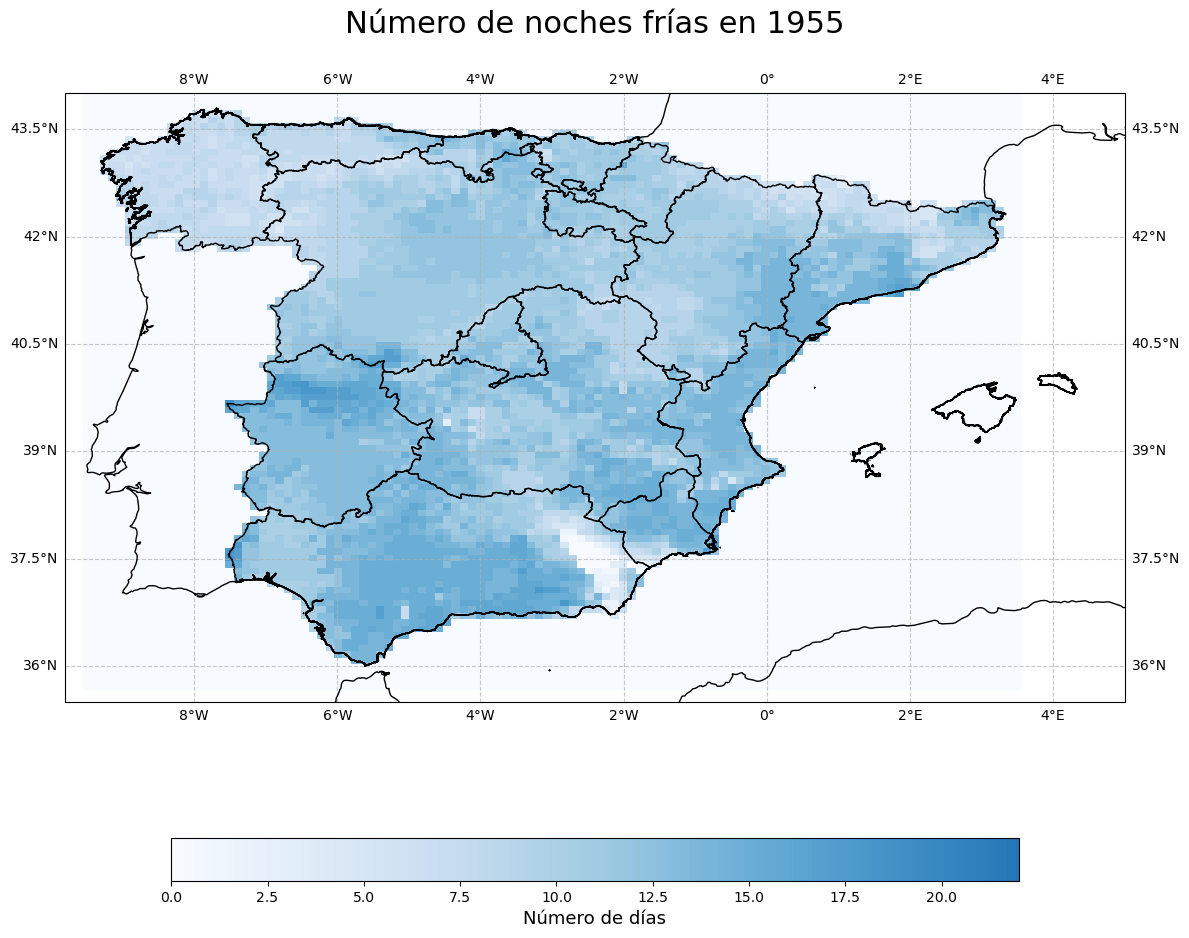

In [190]:
plt.style.use('default')
  
# Para pintar los bordes de las comunidades autónomas se utilizan datos de https://gadm.org/download_country.html
fname = 'datos_indices/mapas/gadm41_ESP_1.shp'
adm1_shapes = list(shpreader.Reader(fname).geometries())

year= 1955
# Creamos la figura
fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
plt.suptitle('Número de noches frías en '+str(year),size=22)

# A partir de aquí vamos a pintar los valores promedio de noches frías en el periodo empleado   
cmap = 'Blues'
var = num_nochesfrias_remallado.sel(time=year)
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=30, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que están los datos 

#print(var.max().squeeze())

# Pintamos las líneas de costa y las fronteras de comunidades
ax.coastlines(resolution='10m')
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)
ax.set_global() 
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1) # Añadimos ejes
ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree()) # Fijamos los límites del plot


# Barra de color 
cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8) 
cbar.set_label(label='Número de días',size=13)
cbar.ax.set_xlim(0, 22) # Al poner los mismos vmin y vmax aseguramos que la escala sea consistente en cada parte

plt.tight_layout()

In [220]:
nt,nlat,nlon=num_nochesfrias_remallado.shape
reshape= np.reshape(np.array(num_nochesfrias_remallado), (nt,nlat*nlon))
anomalia= (reshape-reshape.mean(axis=0))

def quitonans(mat):
    out = mat[:,~np.isnan(mat.mean(axis = 0))]
    return out

tn10_primavera_sin_nan=quitonans(anomalia)

C=np.dot(np.transpose(tn10_primavera_sin_nan),tn10_primavera_sin_nan)
eof_tn10,d_tn10,eof2_tn10=linalg.svd(C)

fvar_tn10=(d_tn10)/sum(d_tn10)
sum(fvar_tn10[:10])

0.9088849086864657

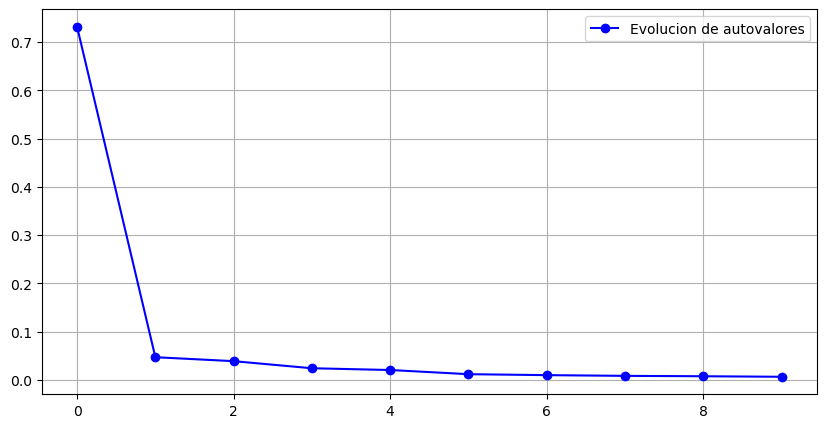

In [221]:
fig,ax = plt.subplots(figsize = (10,5))
plt.plot(fvar_tn10[:10],color='Blue',marker='o',label='Evolucion de autovalores')
plt.legend()
plt.grid()

Text(0.5, 1.0, 'Primera componente principal fvar=0.73')

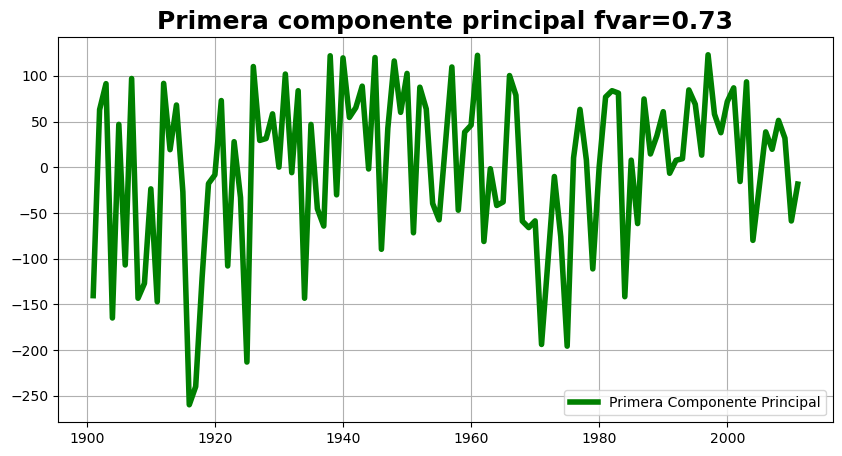

In [222]:
PC=np.dot(tn10_primavera_sin_nan,eof_tn10)
PCs=(PC-np.mean(PC))/np.std(PC)
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1901,2012),PCs[:,0],linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('Primera componente principal fvar='+ str( round(fvar_tn10[0],2)),fontsize=18,weight='bold')

Text(0.5, 1.0, 'segunda componente principal fvar=0.05')

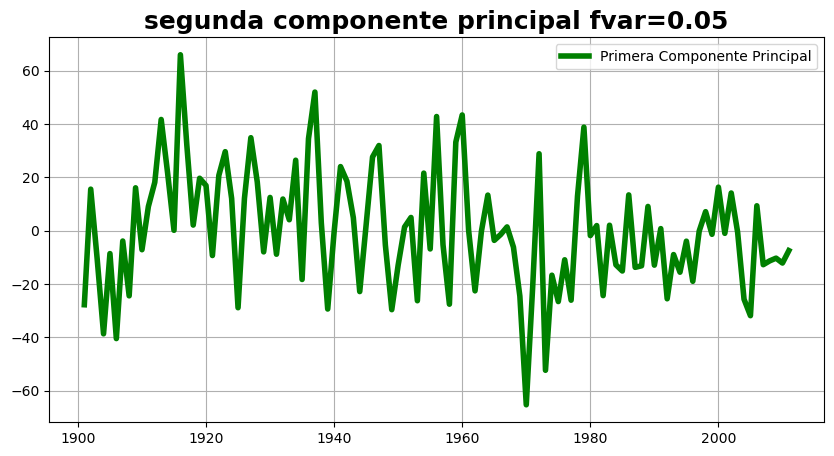

In [223]:
fig,ax=plt.subplots(figsize = (10,5))
ax.plot(range(1901,2012),PCs[:,1],linewidth= 4,color='green',label='Primera Componente Principal')
ax.grid()
ax.legend()
ax.set_title('segunda componente principal fvar='+ str( round(fvar_tn10[1],2)),fontsize=18,weight='bold')

In [198]:
# función pearsonr para y 2D, x 1D
def pearsonr_2D(y, x):
    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    rho = upper / lower
    return rho


# función para calcular correlaciones y regresiones
def IndexRegression(Data,Index,alfa,sig,pp): #Data es el elemento que queremos con el que queremos correlacionar
    try:
        [ns,nt]=Data.shape # n1=espacio, n2=tiempo
    except ValueError:
        # si Data es un índice
        ns=1
        nt=len(Data)
        Data = np.array([Data])
        
    cor=ma.empty([ns,])
    Pvalue=ma.empty([ns,])
    reg=np.dot(Data,Index)/(nt-1) #reg es el mapa de regresion
    for nn in range(ns):  #correlaciona nuestra serie con cada punto
        bb=pearsonr(Data[nn,:],Index) 
        cor[nn]=bb[0]
        Pvalue[nn]=bb[1]

    if sig == 'test-t': #le ponemos la mascara para que no dibuje la regresion cuando el pvalue es mayor que alfa
        cor_sig=ma.masked_where(Pvalue>alfa,cor)
        reg_sig=ma.masked_where(Pvalue>alfa,reg)
        
    if sig == 'MonteCarlo': #primero calcula la correlacion, luego calcula entre los datos y una permutacion aleatoria del índice (np.random.permutatio)
        corp = ma.empty([ns,pp])
        for p in range(pp):
            corp[:,p] = pearsonr_2D(Data,np.random.permutation(Index)) #index es el numero de veces que permuta
            # aquí uso la función pearsonr_2D y me ahorro un bucle en ns
        
        for nn in range(ns): 
            hcor = np.count_nonzero((cor[nn]>0)&(corp[nn,:]<cor[nn])|(cor[nn]<0)&(corp[nn,:]>cor[nn])) #cuenta el numero de veces que se correlaciona de manera aleatoria 
            #es menos que la que hemos obtenido originalmente de los datos, lo cual nos da el nivel de confizan, que luego será lo que enmascaremos
            # nivel de confianza
            Pvalue[nn] = hcor/pp
            
        cor_sig = ma.masked_where(Pvalue<(1-alfa),cor)
        reg_sig = ma.masked_where(Pvalue<(1-alfa),reg)
        
    return cor,Pvalue,cor_sig,reg,reg_sig 

In [224]:
cor1,Pvalue1,cor_sig1,reg1,reg1_sig=IndexRegression(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs[:,0]),0.01,'MonteCarlo',100) 
cor2,Pvalue2,cor_sig2,reg2,reg2_sig=IndexRegression(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs[:,1]),0.01,'MonteCarlo',100)
cor3,Pvalue3,cor_sig3,reg3,reg3_sig=IndexRegression(np.transpose(tn10_primavera_sin_nan),np.transpose(PCs[:,2]),0.01,'MonteCarlo',100)

C:\Anaconda\envs\analisisdatosucm\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\ideapad 5 15ITL05\AppData\Local\Temp\ipykernel_34356\1186345931.py:5: RuntimeWarning: invalid value encountered in divide
  rho = upper / lower


In [231]:
def dibujo_1_mapa_cartopy(A,lon,lat,levs,cmap1,l1,titulo, ax):
    im=ax.contourf(lon,lat,A
                   ,cmap=cmap1,levels=levs,extend='both',transform=ccrs.PlateCarree())
    ax.coastlines(linewidth=2);
    ax.set_title(titulo,fontsize=28)
    cbar = plt.colorbar(im, extend='neither', spacing='proportional',
                orientation='vertical', shrink=0.7, format="%.2f")
    cbar.set_label(l1, size=28)
    cbar.ax.tick_params(labelsize=28) 

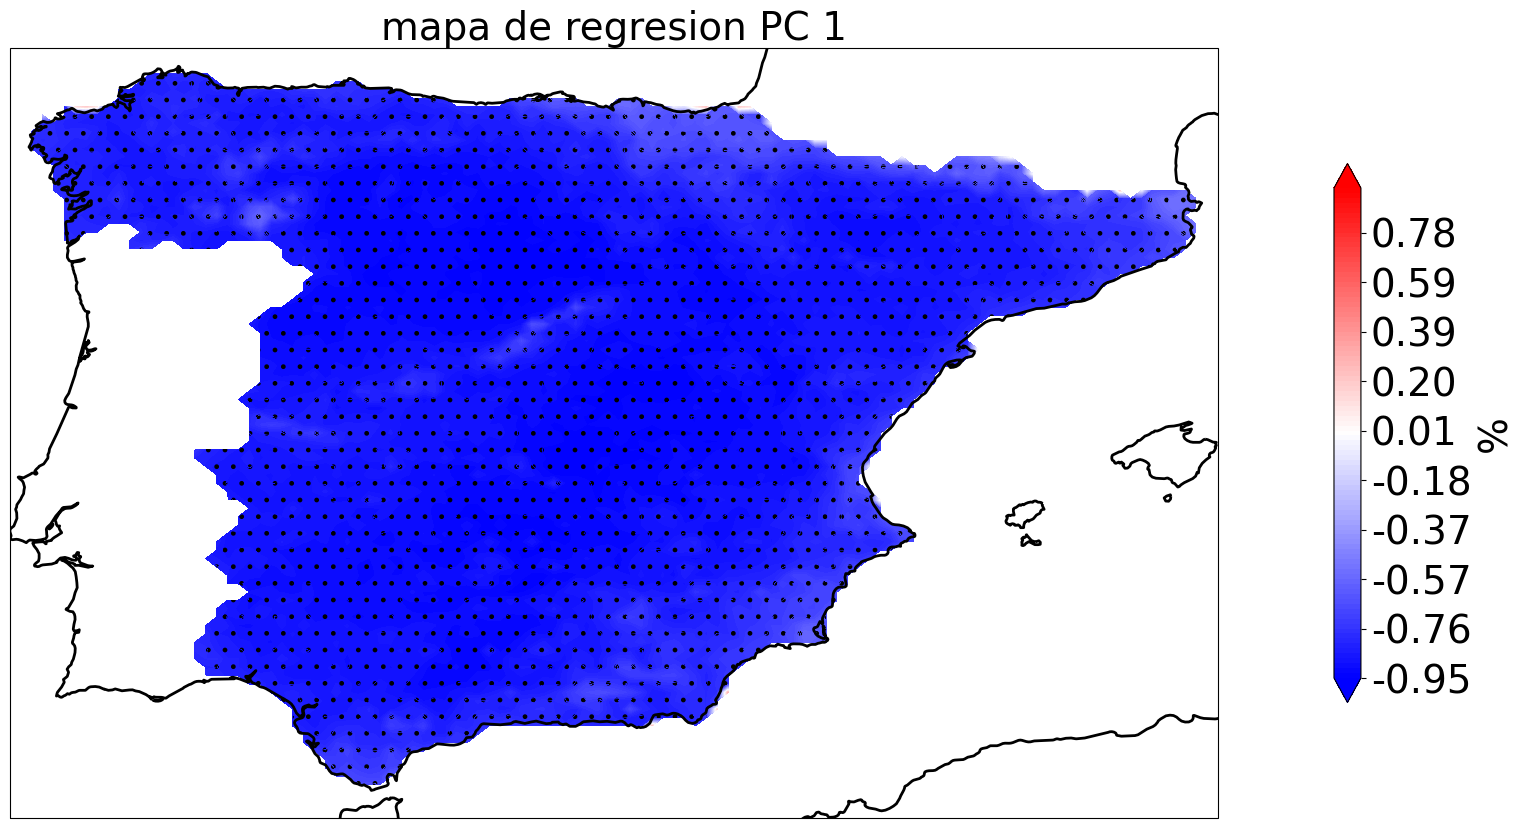

In [235]:
mat=np.expand_dims((num_nochesfrias_remallado)[0],axis=0)
reg1_final=pongonans(np.squeeze(reg1),mat)
reg_sig_1_final=pongonans(np.squeeze(reg1_sig),mat)

cor1_final=pongonans(np.squeeze(cor1),mat)
cor_sig1_final=pongonans(np.squeeze(cor_sig1),mat)

rango_reg=max(abs(np.nanmin(cor1_final)),abs(np.nanmax(cor1_final)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(cor1,(nlat,nlon)),lon,lat,levels,'bwr','%','mapa de correlacion PC 1', ax)
ax.contourf(lon,lat,np.reshape(cor_sig1,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')

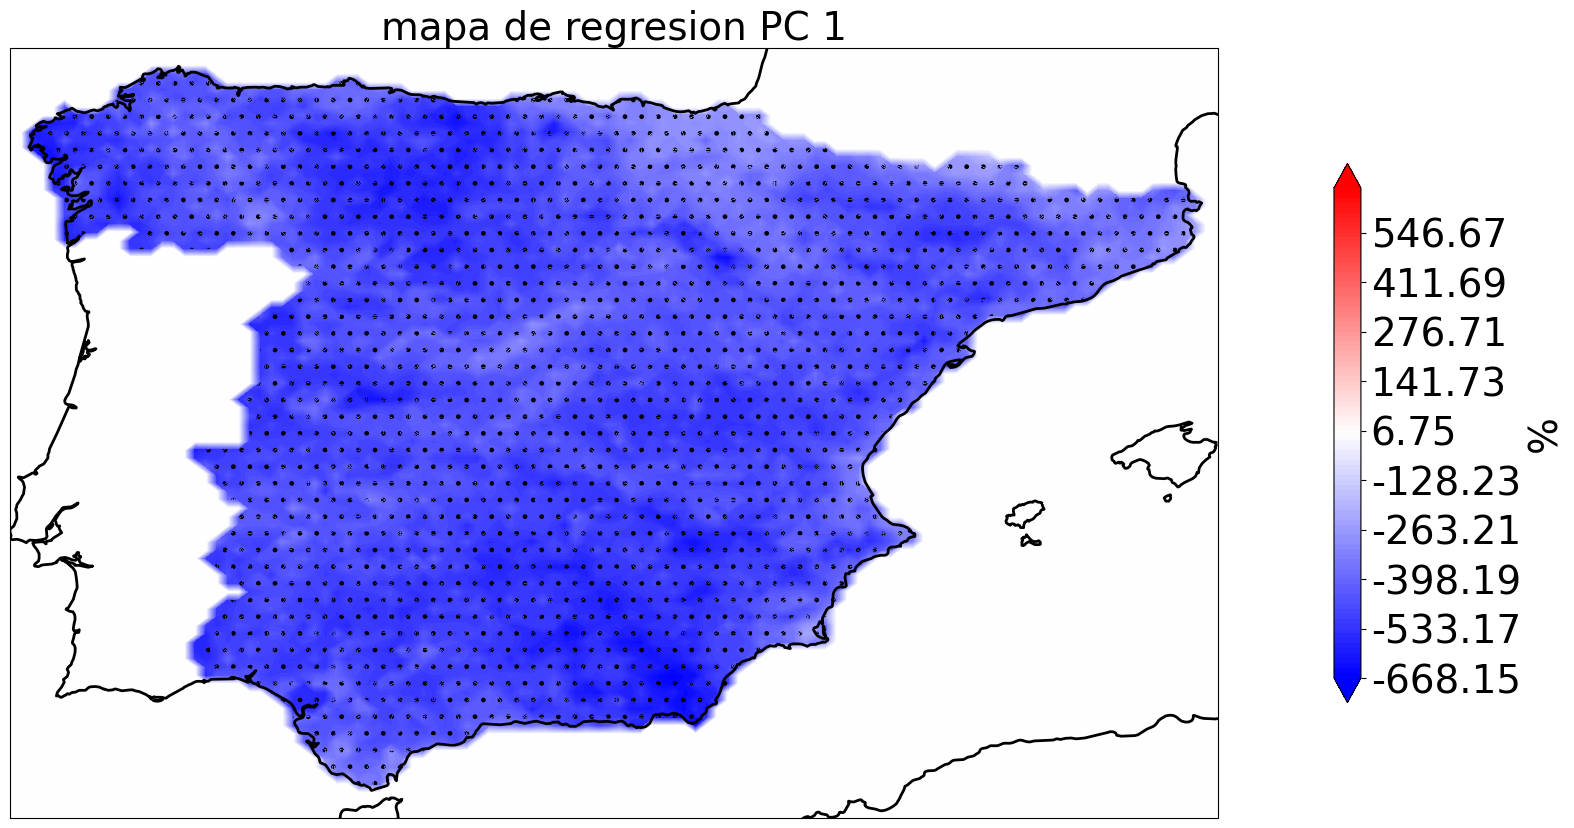

In [238]:
rango_reg=max(abs(np.nanmin(reg1_final)),abs(np.nanmax(reg1_final)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg1,(nlat,nlon)),lon,lat,levels,'bwr','%','mapa de regresion PC 1', ax)
ax.contourf(lon,lat,np.reshape(reg1_sig,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')

In [ ]:
rango_reg=max(abs(np.nanmin(reg2_final)),abs(np.nanmax(reg_sig_2_final)))
levels=np.linspace(-rango_reg,rango_reg,100)

fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg2_final,(nlat,nlon)),lon,lat,levels,'bwr','%','mapa de regresion PC 2', ax)
ax.contourf(lon,lat,np.reshape(reg_sig_2_final,(nlat,nlon)),alfa=0,cmap='bwr',levels=levels,hatches='.')

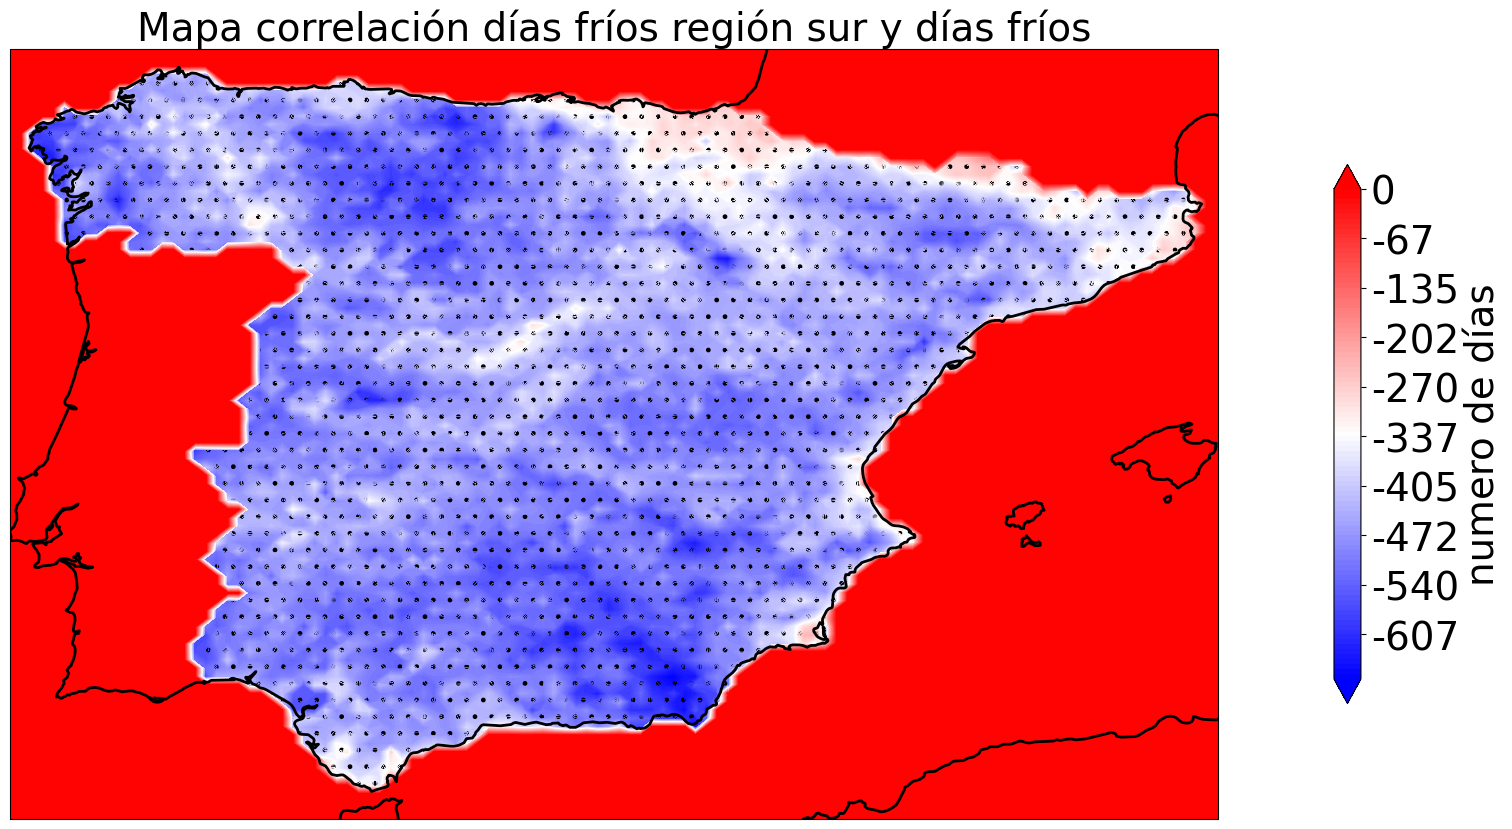

In [226]:


fig = plt.figure(figsize=(30,10)) 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))
dibujo_1_mapa_cartopy(np.reshape(reg1,(nlat,nlon)),var.lon,var.lat,np.linspace(reg1.min(),reg1.max(),100),'bwr','numero de días','Mapa correlación días fríos región sur y días fríos', ax)
ax.contourf(var.lon,var.lat,np.reshape(reg1_sig,(nlat,nlon)),cmap='bwr',levels=np.linspace(reg1_sig.min(),reg1_sig.max(),100),hatches='.')